In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/HCCI.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,15.500000,16.200001,15.19,16.030001,16.030001,29300
1,1/3/2013,16.120001,16.260000,15.21,16.040001,16.040001,12900
2,1/4/2013,16.090000,16.780001,15.99,16.370001,16.370001,24300
3,1/7/2013,16.370001,16.450001,15.88,15.880000,15.880000,28400
4,1/8/2013,15.930000,16.469999,15.59,16.180000,16.180000,47800


In [3]:
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\Magda\anaconda3\lib\site-packages\ipykernel_launcher.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


epoch: 10, total rewards: 27.729989.3, cost: -33987.011719, total money: 10027.729989
epoch: 20, total rewards: 46.950000.3, cost: -34268.945312, total money: 10046.950000
epoch: 30, total rewards: 121.839990.3, cost: -34457.429688, total money: 10121.839990
epoch: 40, total rewards: 216.789984.3, cost: -34645.238281, total money: 10216.789984
epoch: 50, total rewards: 215.619978.3, cost: -34787.113281, total money: 10215.619978
epoch: 60, total rewards: 466.819984.3, cost: -34383.425781, total money: 10073.939985
epoch: 70, total rewards: 484.629980.3, cost: -34551.054688, total money: 10392.039979
epoch: 80, total rewards: 371.209979.3, cost: -34793.871094, total money: 10371.209979
epoch: 90, total rewards: 508.169990.3, cost: -34672.070312, total money: 10476.469990
epoch: 100, total rewards: 776.039985.3, cost: -33958.652344, total money: 9537.929980
epoch: 110, total rewards: 611.379981.3, cost: -34373.011719, total money: 10012.949979
epoch: 120, total rewards: 698.569986.3, cos

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 7: buy 1 unit at price 15.240000, total balance 9984.760000
day 10: buy 1 unit at price 14.670000, total balance 9970.090000
day 12, sell 1 unit at price 14.650000, investment -3.871392 %, total balance 9984.740000,
day 14, sell 1 unit at price 14.780000, investment 0.749827 %, total balance 9999.520000,
day 19: buy 1 unit at price 15.760000, total balance 9983.759999
day 21: buy 1 unit at price 15.980000, total balance 9967.780000
day 23: buy 1 unit at price 15.810000, total balance 9951.969999
day 24: buy 1 unit at price 15.620000, total balance 9936.349999
day 27: buy 1 unit at price 15.680000, total balance 9920.669999
day 28: buy 1 unit at price 15.540000, total balance 9905.129999
day 30: buy 1 unit at price 15.050000, total balance 9890.079999
day 31: buy 1 unit at price 15.240000, total balance 9874.839999
day 32: buy 1 unit at price 15.310000, total balance 9859.529999
day 33, sell 1 unit at price 15.220000, investment -3.426396 %, total balance 9874.749999,
day 34, sell 1

day 191, sell 1 unit at price 18.020000, investment 17.394137 %, total balance 9827.869993,
day 193, sell 1 unit at price 18.420000, investment 20.707731 %, total balance 9846.289993,
day 194, sell 1 unit at price 17.940001, investment 17.101834 %, total balance 9864.229994,
day 195: buy 1 unit at price 18.010000, total balance 9846.219994
day 196: buy 1 unit at price 18.139999, total balance 9828.079994
day 202, sell 1 unit at price 18.150000, investment 20.598003 %, total balance 9846.229994,
day 203, sell 1 unit at price 18.219999, investment 19.397110 %, total balance 9864.449993,
day 204: buy 1 unit at price 18.200001, total balance 9846.249992
day 207: buy 1 unit at price 17.980000, total balance 9828.269993
day 211, sell 1 unit at price 17.520000, investment 14.885249 %, total balance 9845.789993,
day 212, sell 1 unit at price 17.610001, investment 15.475414 %, total balance 9863.399994,
day 213, sell 1 unit at price 17.590000, investment 15.571615 %, total balance 9880.989994,


day 381: buy 1 unit at price 17.530001, total balance 9990.409981
day 382: buy 1 unit at price 17.170000, total balance 9973.239981
day 384: buy 1 unit at price 17.309999, total balance 9955.929981
day 386: buy 1 unit at price 17.080000, total balance 9938.849981
day 388: buy 1 unit at price 17.129999, total balance 9921.719982
day 389, sell 1 unit at price 17.049999, investment -10.451689 %, total balance 9938.769981,
day 390, sell 1 unit at price 17.049999, investment -7.236126 %, total balance 9955.819981,
day 391: buy 1 unit at price 17.059999, total balance 9938.759981
day 392, sell 1 unit at price 17.250000, investment -1.597266 %, total balance 9956.009981,
day 394, sell 1 unit at price 17.430000, investment 1.514270 %, total balance 9973.439981,
day 395, sell 1 unit at price 17.270000, investment -0.231075 %, total balance 9990.709982,
day 396: buy 1 unit at price 17.549999, total balance 9973.159983
day 397: buy 1 unit at price 16.959999, total balance 9956.199984
day 398: buy

day 553: buy 1 unit at price 13.110000, total balance 9834.519982
day 554: buy 1 unit at price 13.040000, total balance 9821.479982
day 555: buy 1 unit at price 12.840000, total balance 9808.639982
day 557, sell 1 unit at price 12.130000, investment -4.186412 %, total balance 9820.769982,
day 558, sell 1 unit at price 11.790000, investment -7.018930 %, total balance 9832.559982,
day 559: buy 1 unit at price 11.890000, total balance 9820.669982
day 560, sell 1 unit at price 11.000000, investment -14.794732 %, total balance 9831.669982,
day 562, sell 1 unit at price 11.440000, investment -11.041992 %, total balance 9843.109981,
day 563: buy 1 unit at price 12.080000, total balance 9831.029982
day 564: buy 1 unit at price 11.700000, total balance 9819.329982
day 565, sell 1 unit at price 12.330000, investment -2.529642 %, total balance 9831.659982,
day 566, sell 1 unit at price 12.650000, investment -0.078991 %, total balance 9844.309981,
day 567, sell 1 unit at price 12.860000, investmen

day 793: buy 1 unit at price 7.640000, total balance 9821.889974
day 795, sell 1 unit at price 8.010000, investment -24.433963 %, total balance 9829.899975,
day 797: buy 1 unit at price 8.390000, total balance 9821.509974
day 798: buy 1 unit at price 8.810000, total balance 9812.699974
day 800: buy 1 unit at price 8.910000, total balance 9803.789974
day 801: buy 1 unit at price 8.960000, total balance 9794.829974
day 802: buy 1 unit at price 8.480000, total balance 9786.349975
day 803: buy 1 unit at price 8.800000, total balance 9777.549974
day 809, sell 1 unit at price 9.230000, investment -10.126591 %, total balance 9786.779974,
day 810, sell 1 unit at price 9.200000, investment 0.987927 %, total balance 9795.979974,
day 812, sell 1 unit at price 9.200000, investment -3.563943 %, total balance 9805.179974,
day 816: buy 1 unit at price 9.940000, total balance 9795.239974
day 818: buy 1 unit at price 9.950000, total balance 9785.289974
day 821, sell 1 unit at price 10.230000, investmen

day 1003: buy 1 unit at price 15.900000, total balance 9682.889973
day 1005, sell 1 unit at price 15.850000, investment 18.904730 %, total balance 9698.739973,
day 1007, sell 1 unit at price 15.700000, investment 17.602991 %, total balance 9714.439973,
day 1009, sell 1 unit at price 15.500000, investment 16.104866 %, total balance 9729.939973,
day 1012, sell 1 unit at price 14.600000, investment 14.330461 %, total balance 9744.539973,
day 1013, sell 1 unit at price 14.900000, investment 11.777942 %, total balance 9759.439973,
day 1016: buy 1 unit at price 14.900000, total balance 9744.539973
day 1017, sell 1 unit at price 14.500000, investment 9.765329 %, total balance 9759.039973,
day 1020: buy 1 unit at price 14.300000, total balance 9744.739973
day 1021, sell 1 unit at price 14.850000, investment 15.205586 %, total balance 9759.589973,
day 1023: buy 1 unit at price 15.350000, total balance 9744.239973
day 1024, sell 1 unit at price 15.000000, investment 11.690243 %, total balance 97

day 1209, sell 1 unit at price 20.350000, investment 30.448717 %, total balance 9499.009979,
day 1210: buy 1 unit at price 19.830000, total balance 9479.179979
day 1211: buy 1 unit at price 18.850000, total balance 9460.329979
day 1212: buy 1 unit at price 19.400000, total balance 9440.929979
day 1213, sell 1 unit at price 19.200001, investment 23.076925 %, total balance 9460.129980,
day 1214, sell 1 unit at price 19.350000, investment 22.082018 %, total balance 9479.479980,
day 1216, sell 1 unit at price 19.200001, investment 23.870973 %, total balance 9498.679981,
day 1217, sell 1 unit at price 19.549999, investment 25.723466 %, total balance 9518.229980,
day 1219: buy 1 unit at price 19.850000, total balance 9498.379980
day 1220: buy 1 unit at price 20.000000, total balance 9478.379980
day 1223: buy 1 unit at price 19.500000, total balance 9458.879980
day 1224: buy 1 unit at price 19.400000, total balance 9439.479980
day 1226: buy 1 unit at price 18.950001, total balance 9420.529980

day 1429: buy 1 unit at price 23.600000, total balance 9334.329977
day 1430: buy 1 unit at price 23.000000, total balance 9311.329977
day 1433, sell 1 unit at price 22.400000, investment 9.268291 %, total balance 9333.729977,
day 1434, sell 1 unit at price 21.799999, investment 8.999996 %, total balance 9355.529976,
day 1435, sell 1 unit at price 21.400000, investment 6.999998 %, total balance 9376.929975,
day 1436: buy 1 unit at price 21.650000, total balance 9355.279976
day 1437, sell 1 unit at price 21.049999, investment -10.615712 %, total balance 9376.329975,
day 1438: buy 1 unit at price 21.000000, total balance 9355.329975
day 1440, sell 1 unit at price 21.049999, investment -9.656653 %, total balance 9376.379974,
day 1441: buy 1 unit at price 20.600000, total balance 9355.779974
day 1442, sell 1 unit at price 20.500000, investment -13.865543 %, total balance 9376.279974,
day 1444, sell 1 unit at price 21.049999, investment -9.850112 %, total balance 9397.329973,
day 1445: buy 1

day 1649: buy 1 unit at price 27.629999, total balance 9356.349972
day 1650: buy 1 unit at price 28.510000, total balance 9327.839971
day 1651: buy 1 unit at price 28.139999, total balance 9299.699972
day 1652: buy 1 unit at price 28.730000, total balance 9270.969973
day 1653: buy 1 unit at price 28.040001, total balance 9242.929972
day 1654, sell 1 unit at price 28.090000, investment 19.328798 %, total balance 9271.019972,
day 1657: buy 1 unit at price 27.750000, total balance 9243.269972
day 1660, sell 1 unit at price 26.740000, investment 13.981248 %, total balance 9270.009972,
day 1661: buy 1 unit at price 26.910000, total balance 9243.099972
day 1662: buy 1 unit at price 26.250000, total balance 9216.849972
day 1664, sell 1 unit at price 25.930000, investment 3.512978 %, total balance 9242.779972,
day 1665, sell 1 unit at price 25.090000, investment 0.884597 %, total balance 9267.869972,
day 1666, sell 1 unit at price 25.340000, investment 2.466642 %, total balance 9293.209972,
da

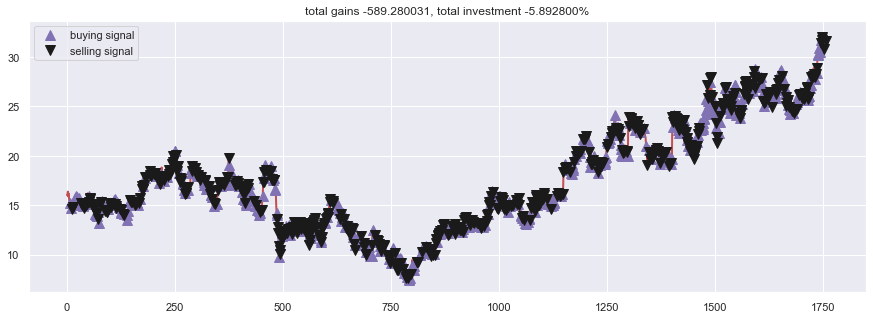

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()